In [12]:
%matplotlib inline

# Introduction

This notebook tests the new feature "Recobundles" from https://github.com/nipy/dipy/pull/1443#issuecomment-373049087

https://www.sciencedirect.com/science/article/pii/S1053811917305839

## Take 2: Pre-Registration

Added pre-registration to tailor the template to the dataset, and performance improved greatly. The recognized bundles tend to include extra sub-bundles similar to the template. Enforcing single-template membership for each streamline would probably help with this. Refinement of the template would also improve performance; this was using a manually-cleaned single subject as a template. Note: Prisma cases were corrected for susceptibility distortion. The template was made from a case scanned on the Prisma.

Notes from visual inspection (N=1 test brain against N=1 template brain on N=2 scanners):

IFOF
- very good

ILF
- pretty good; a few sub-bundles to clean up (endpoints would help)

UNCINATE
- Some extra sub-bundles, especially short/high turning angle tracks. Frontal targets may help
- There's a debate on what sub-bundles should be included in uncinate... maybe more specific template separating the different components would be helpful
    
ARCUATE/SLF COMPLEX (includes 3 tracks: Arcuate, SLF ip, SLF tp)
- Some mixing SLFip vs. Arcuate vs. SLFtp, but reasonably good performance
    - Differential templates? (enforce single-template membership)
    - Some truncated Arcuate streamlines are included in SLF-ip; enforcing cortical termination may help
- Arcuate low specificity
    - Some Aslant streamlines in Arcuate
    - Some SLF-ip streamlines in Arcuate
    - differential template may help
    - Enforce single-bundle membership
- SLF ip template had a lot of different sub-bundles... other subjects have much more devined models of SLFII and SLFIII... changing the template to one of those may help considerably
- SLF tp has a lot of other sub-bundles; perhaps a differential template?

ASLANT
- pretty good 
- There is an extra branch apparent on the coronal view
- Greater anterior-posterior extent of bundle
    - Differential templates may help to select a particular segment of this larger bundle



NOTES FROM @Garyfallidis

- Pre-registration is assumed

- Pruning threshold most important

- Use multiple streamline distances

# Import/Define Functions

In [278]:
import os
from glob import glob

import nibabel as nib
import numpy as np

from dipy.tracking.distances import bundles_distances_mam
from dipy.tracking.streamline import Streamlines
from dipy.segment.bundles import RecoBundles
from dipy.segment.clustering import qbx_with_merge
from dipy.data import get_data
from dipy.align.streamlinear import whole_brain_slr, slr_with_qb, transform_streamlines
from dipy.tracking.utils import length

from IPython.display import display, HTML, Image

In [14]:
def make_html(path_list):
    myhtml = ''
    for path in path_list:
        myhtml+='<img src="{}" style="float: left; width: 40%; margin-right: 1%; margin-bottom: 0.5em;"/>'.format(path)
    return myhtml

In [15]:
from dipy.viz import window, actor

def genren(sls, sls2=None, niidata=None, roi1=None, roi2=None, aff=None, putpath=None, show=False, orient=True, colors=[(1,1,1)]):
    
    renderer = window.Renderer()
    
    if len(colors)>1:
        stream_actor = actor.line(sls, colors=colors[1])
    else:
        stream_actor=actor.line(sls)
        
    renderer.add(stream_actor)
    
    if sls2 is not None:
        stream_actor2 = actor.line(sls2, colors=colors[0])
        renderer.add(stream_actor2)
    
    if roi1 is not None and roi2 is not None:
        
        contour_actor1 = actor.contour_from_roi(roi1, affine=aff, color=(1., 1., 0.),
                                          opacity=0.5)
        contour_actor2 = actor.contour_from_roi(roi2, affine=aff, color=(1., 0., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor1)
        renderer.add(contour_actor2)
        
    
    if niidata is not None:
        slice_actor = actor.slicer(niidata, affine=aff)
        renderer.add(slice_actor)

    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #                    focal_point=(113.30, 128.31, 76.56),
    #                    view_up=(0.18, 0.00, 0.98))

    if orient:
        axes_actor = actor.axes(scale=(10, 10, 10), colorx=(1, 0, 0), colory=(0, 1, 0), colorz=(0, 0, 1), opacity=1)
        #Create an actor with the coordinate’s system axes where red = x, green = y, blue = z.
        renderer.add(axes_actor)

    if show:
        window.show(renderer, size=(600, 600), reset_camera=False)
    if putpath is not None:
        window.record(renderer, out_path=putpath, size=(600, 600))
    del renderer
    return putpath

In [349]:
def run_rb(templatesls, bucketosls, cluster_map=None, pruning_thr=5):
    # try pruning thresh 10 if not specific drop to 5
    if cluster_map is None:
        cluster_map = qbx_with_merge(bucketosls, thresholds=[40, 25, 20, 10])
    else:
        print("Loading provided cluster map")

    rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=5)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=5.,
                                                         reduction_thr=10, pruning_thr=pruning_thr)
    '''rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=10)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=1.)'''
    #D = bundles_distances_mam(templatesls, recognized)
    
    return recognized, cluster_map

In [205]:
def rough_reg(sub_fixed, temp_moving):
    #template moves to the subject space
    #qb_thr=5 errored
    moved, transform, qb_centroids1, qb_centroids2 = whole_brain_slr(sub_fixed, temp_moving, 
                                                                     verbose=True,
                                                                     progressive=True)
    return moved, transform, qb_centroids1, qb_centroids2

This is taking a very long time (large datasets)... there is probably a reasonable subsampling that will universally suffice... perhaps reducing the streamline dataset prior to running the quickbundles would help? (maybe a flag that is defaulted to false to specify if the user really wants all streamlines represented?)

In [279]:
def filter_length(streamlines, minlen=40):
    print("calc lengths")
    lengths = list(length(streamlines))
    print("filter")
    long_sls = []
    for i,sl in enumerate(streamlines):
        if lengths[i] > minlen:
            long_sls.append(sl)
    return long_sls

# Find paths/load data

In [284]:
putdir = 'output_Kesh_Test_Recobundles_testing_elefsugg_long'
if not os.path.exists(putdir):
    os.mkdir(putdir)

In [198]:
def loadtgm_newapi(trkpath):
    trkloaded = nib.streamlines.trk.TrkFile.load(trkpath)
    hdrloaded = trkloaded.header
    tg=trkloaded.tractogram
    return tg

Whole brain from Prisma and Trio (same brain)

In [199]:
wb_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob_gt40mm_good.trk'
wb_prisma_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob.trk'
wb_trio_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/Whole_Brain_bs_prob.trk'

#single case gold standard
gs_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/'
gs_trio_path = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/'

#single case template
pathpath = '/Users/kesshijordan/paths/recobundles_template_basepath.txt'
with open(pathpath, 'r') as myfile:
    template_basepath = myfile.read().replace('\n', '').replace('\'','')

# Prisma Whole Brain Dataset from Subject

In [200]:
#Nice streamlines
#wb_prisma_tg = loadtgm_newapi(wb_prisma_path)
#wb_prisma_sls = wb_prisma_tg.streamlines

In [22]:
wb_rawprisma_tg = loadtgm_newapi(wb_prisma_path_raw)
wb_rawprisma_sls = wb_rawprisma_tg.streamlines

In [280]:
wb_longprisma_sls = filter_length(wb_rawprisma_sls)

calc lengths
filter


# Trio Whole Brain Dataset from Subject

In [23]:
wb_rawtrio_tg = loadtgm_newapi(wb_trio_path_raw)
wb_rawtrio_sls = wb_rawtrio_tg.streamlines

In [281]:
wb_longtrio_sls = filter_length(wb_rawtrio_sls)

calc lengths
filter


# Whole Brain Template 

also from subject on prisma

In [24]:
wb_template = os.path.join(template_basepath, '../Whole_Brain_bs.trk')

wb_template_tg = loadtgm_newapi(wb_template)
wb_template_sls = wb_template_tg.streamlines

In [282]:
wb_longtemplate_sls = filter_length(wb_template_sls)

calc lengths
filter


# Pre-register using streamlinear registration with wholebrain

In [285]:
short_wb_prisma_sls = wb_longprisma_sls[::100]
short_wb_trio_sls = wb_longtrio_sls[::100]
short_wb_template_sls = wb_longtemplate_sls[::100]

In [286]:
moved_temp2prisma, xfm_temp2prisma, qbc1_temp2prisma, qbc2_temp2prisma = rough_reg(short_wb_prisma_sls, short_wb_template_sls)

Static streamlines size 9801
Moving streamlines size 10358
Static streamlines after length reduction 7916
Moving streamlines after length reduction 8351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 34
QB moving centroids size 39
SLR finished in  0.254 seconds.
SLR iterations: 54 


In [287]:
moved_temp2trio, xfm_temp2trio, qbc1_temp2trio, qbc2_temp2trio = rough_reg(short_wb_trio_sls, short_wb_template_sls)

Static streamlines size 8575
Moving streamlines size 10358
Static streamlines after length reduction 6929
Moving streamlines after length reduction 8351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 22
QB moving centroids size 39
SLR finished in  0.255 seconds.
SLR iterations: 84 


## IFOF

Single case template

NOTE: When I used transform_streamlines, I got an error on recobundles... must be array sequence, NOT list

In [288]:
template = os.path.join(template_basepath, 'IFOF_L.trk')

t_tg_ifof = loadtgm_newapi(template)
t_sls_ifof_prisma = t_tg_ifof.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_ifof_trio = t_tg_ifof.copy().apply_affine(xfm_temp2trio).streamlines

### IFOF Prisma

#### Test Pre-Registration

Before

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


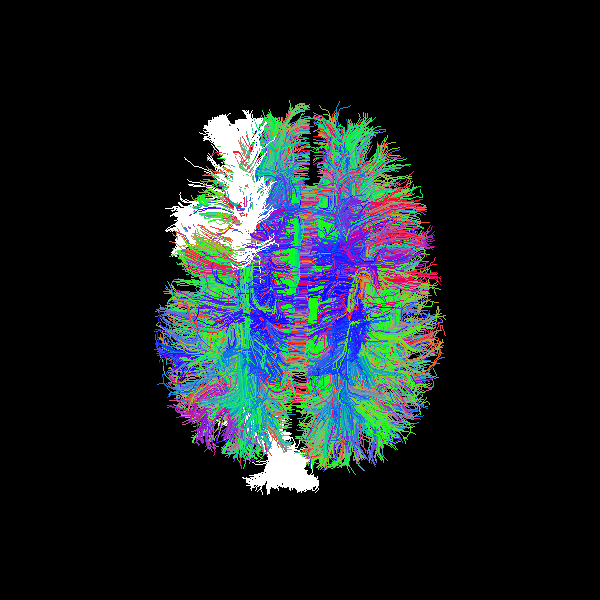

In [289]:
renpath=os.path.join(putdir, 'WB_IFOF_L.png')
genren(wb_longprisma_sls[::100], t_tg_ifof.streamlines, putpath=renpath)
Image(renpath, width=400, height=400)

After

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


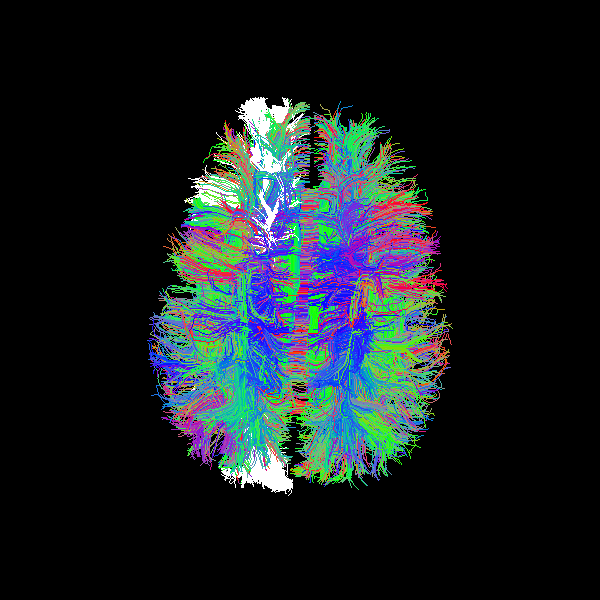

In [290]:
renpath=os.path.join(putdir, 'WB_IFOF_L.png')
genren(wb_longprisma_sls[::100], t_sls_ifof_prisma, putpath=renpath)
Image(renpath, width=400, height=400)

## Check affine... I don't think it's off

In [ ]:
renpath=os.path.join(putdir, 'WB_IFOF_L_checkaff.png')
genren(, t_sls_ifof_prisma, putpath=renpath)
Image(renpath, width=400, height=400)

## Prisma IFOF

Find the template IFOF in the whole brain of another patient

In [294]:
rb_prisma_ifof_L, ig = run_rb(t_sls_ifof_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.010 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.727 sec. 

 Model bundle has 145 centroids
 Duration 0.738 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10651
 Duration 1.220 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.372
 Number of iterations 56
 Matrix size (400, 600)
[[ 0.984 -0.065  0.092  3.836]
 [ 0.057  0.985  0.086  2.788]
 [-0.098 -0.08   0.983  4.993]
 [ 0.     0.     0.     1.   ]]
[ 0.306  1.061  1.167 -4.653  5.65   3.335  0.991]
 Duration 15.613 sec. 

# Prune streamlines using the MDF distance
 Prunin

#### Template IFOF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


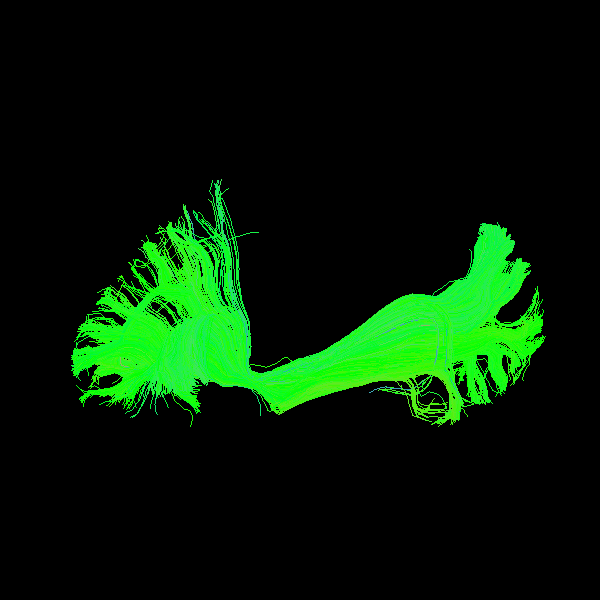

In [177]:
renpath2=os.path.join(putdir, 'template_IFOF_L.png')
genren(t_sls_ifof, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Interestingly, this worked with and without pre-registration

#### Recognized IFOF Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


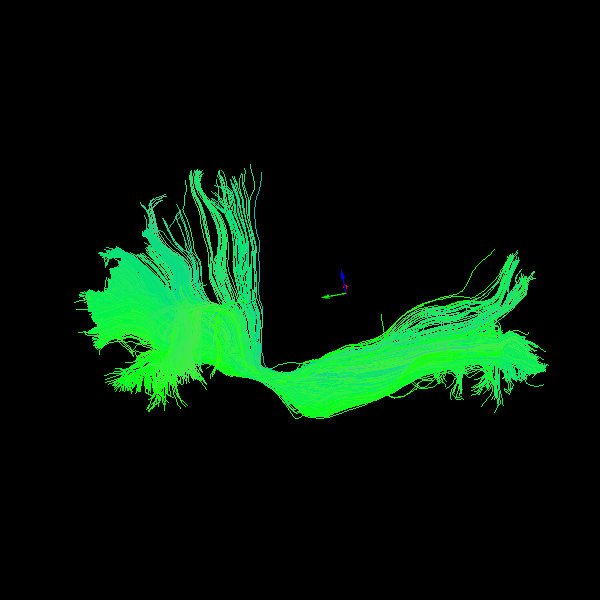

In [295]:
renpath=os.path.join(putdir, 'recognized_IFOF_L.png')
genren(rb_prisma_ifof_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## IFOF Trio

Test with a rescan of the same brain (different scanner/sequence)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


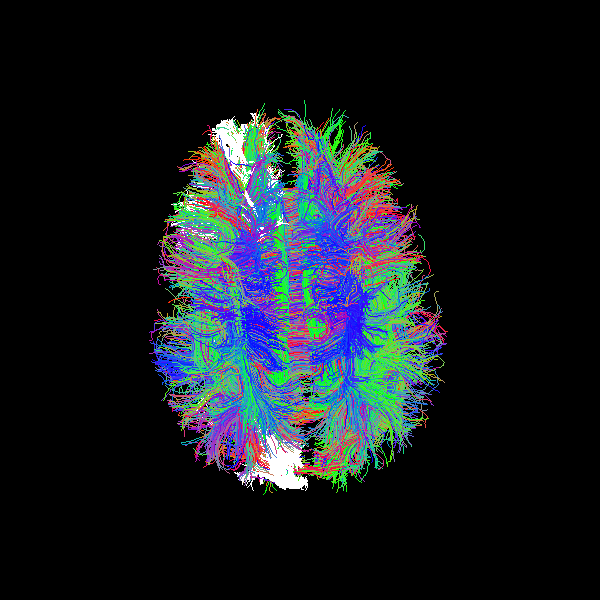

In [296]:
renpath=os.path.join(putdir, 'WB_IFOF_L_TRIO.png')
genren(wb_longtrio_sls[::100], t_sls_ifof_trio, putpath=renpath)
Image(renpath, width=400, height=400)

In [297]:
rb_rawtrio_ifof_L, ig = run_rb(t_sls_ifof_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.010 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.326 sec. 

 Model bundle has 133 centroids
 Duration 0.337 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10300
 Duration 1.454 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.023
 Number of iterations 59
 Matrix size (400, 600)
[[ 0.947 -0.061  0.152 -1.709]
 [ 0.05   0.957  0.07  -0.73 ]
 [-0.156 -0.061  0.946  2.27 ]
 [ 0.     0.     0.     1.   ]]
[-0.289  0.777 -1.946 -3.699  9.329  3.037  0.961]
 Duration 16.818 sec. 

# Prune streamlines using the MDF distance
 Prunin

#### Template IFOF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


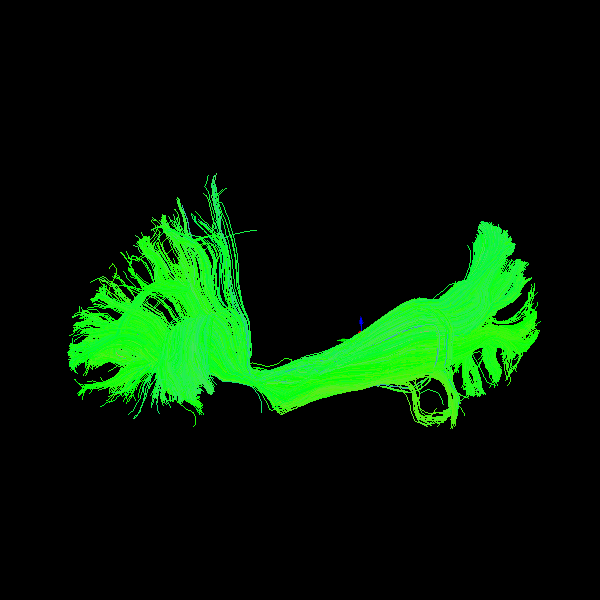

In [217]:
renpath2=os.path.join(putdir, 'template_IFOF_L.png')
genren(t_sls_ifof, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized IFOF Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


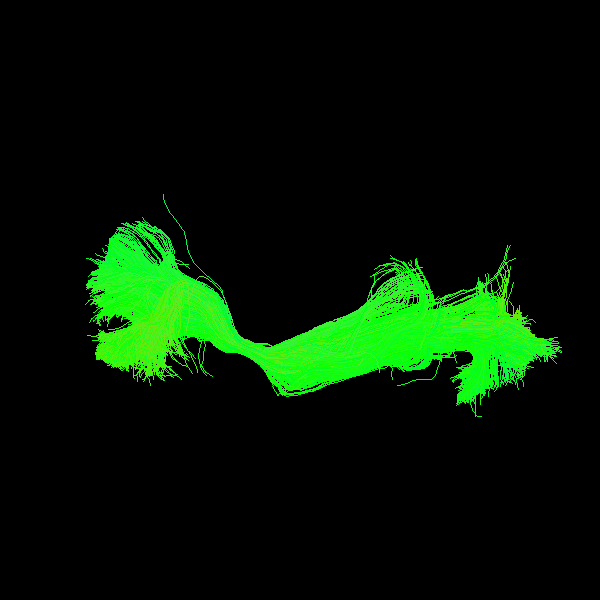

In [298]:
renpath=os.path.join(putdir, 'recognized_IFOF_L_RAW_TRIO.png')
genren(rb_rawtrio_ifof_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

This one failed without preregistration.. With preregistration, however, it works quite well

# ILF

In [299]:
template_ilf = os.path.join(template_basepath, 'ILF_L.trk')

t_tg_ilf = loadtgm_newapi(template_ilf)

t_sls_ilf_prisma = t_tg_ilf.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_ilf_trio = t_tg_ilf.copy().apply_affine(xfm_temp2trio).streamlines

## ILF Prisma

In [300]:
rb_prisma_ilf_L, ig = run_rb(t_sls_ilf_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.124 sec. 

 Model bundle has 78 centroids
 Duration 0.130 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 11666
 Duration 0.759 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.619
 Number of iterations 74
 Matrix size (400, 600)
[[ 0.904  0.036  0.152  2.558]
 [-0.023  0.913 -0.079  3.873]
 [-0.155  0.074  0.901 -2.234]
 [ 0.     0.     0.     1.   ]]
[ 2.747 -0.723  2.954  4.708  9.707 -1.445  0.917]
 Duration 21.683 sec. 

# Prune streamlines using the MDF distance
 Pruning

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


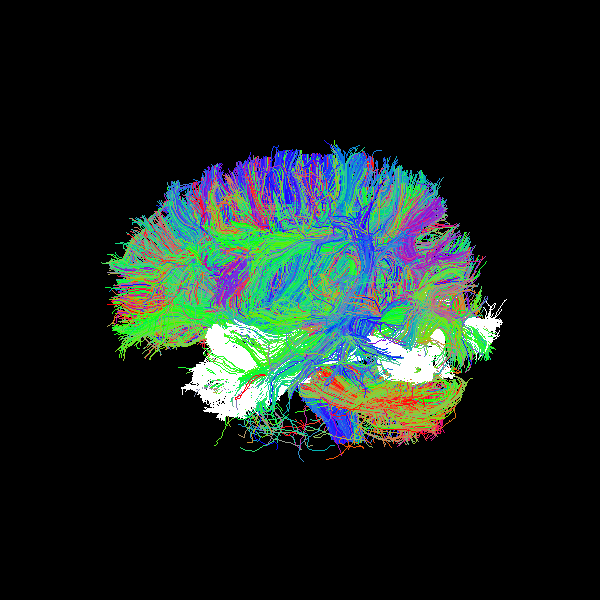

In [301]:
renpath=os.path.join(putdir, 'WB_ILF_L.png')
genren(wb_longprisma_sls[::100], t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template ILF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


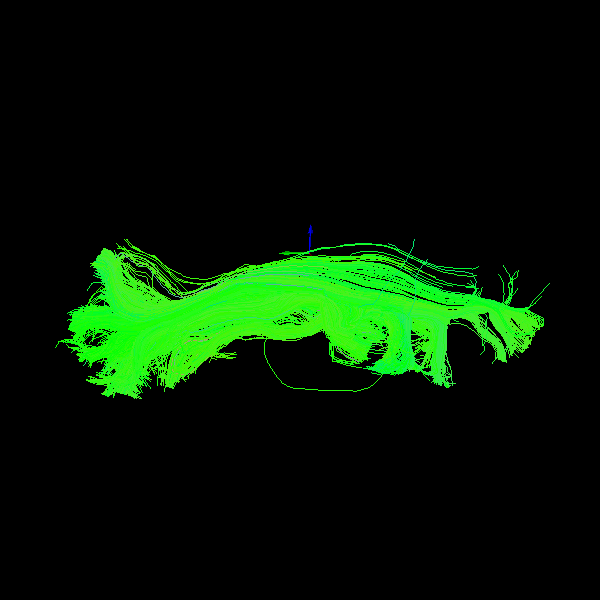

In [222]:
renpath=os.path.join(putdir, 'template_ILF_L.png')
genren(t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized ILF Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


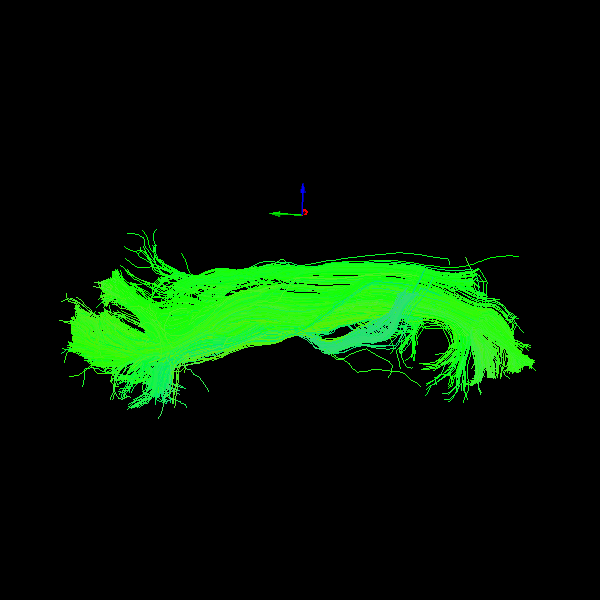

In [302]:
renpath=os.path.join(putdir, 'recognized_ILF_L.png')
genren(rb_prisma_ilf_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## ILF Trio

In [303]:
rb_trio_ilf_L, ig = run_rb(t_sls_ilf_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.122 sec. 

 Model bundle has 76 centroids
 Duration 0.126 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 7138
 Duration 0.771 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.505
 Number of iterations 65
 Matrix size (400, 600)
[[ 0.831  0.04   0.11  -7.609]
 [-0.034  0.837 -0.049  2.403]
 [-0.112  0.044  0.83   2.801]
 [ 0.     0.     0.     1.   ]]
[ 2.892 -0.94   6.75   3.03   7.687 -2.323  0.839]
 Duration 17.145 sec. 

# Prune streamlines using the MDF distance
 Pruning 

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


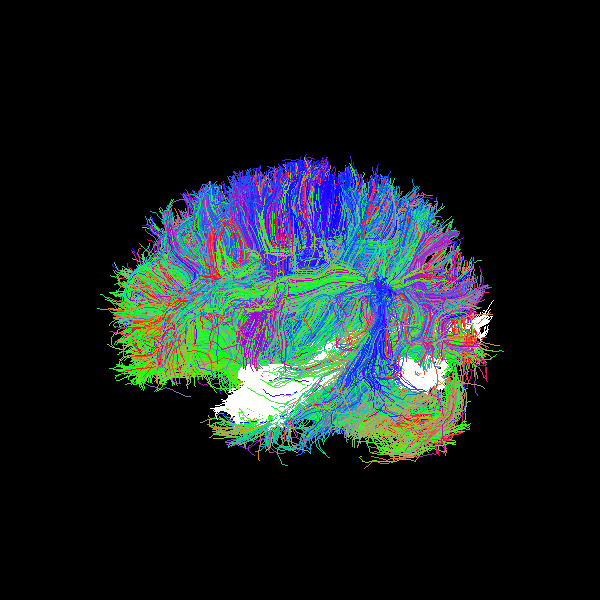

In [304]:
renpath=os.path.join(putdir, 'WB_ILF_L_TRIO.png')
genren(wb_longtrio_sls[::100], t_sls_ilf_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template ILF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


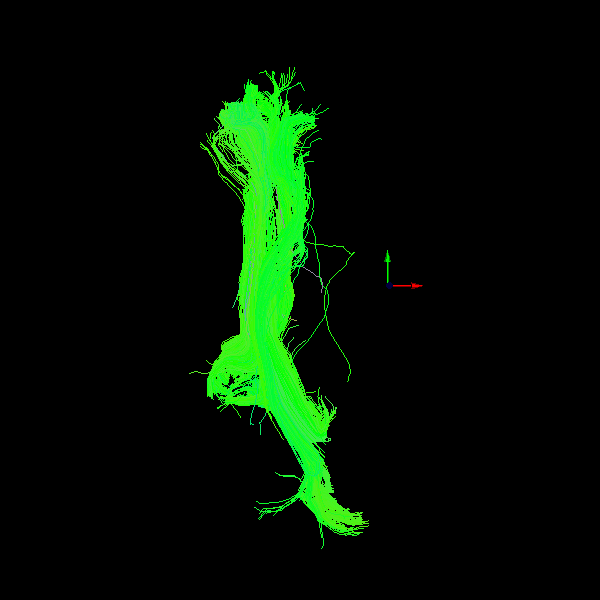

In [226]:
renpath=os.path.join(putdir, 'template_ILF_L.png')
genren(t_sls_ilf, putpath=renpath)
Image(renpath, width=400, height=400)

#### Recognized ILF Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


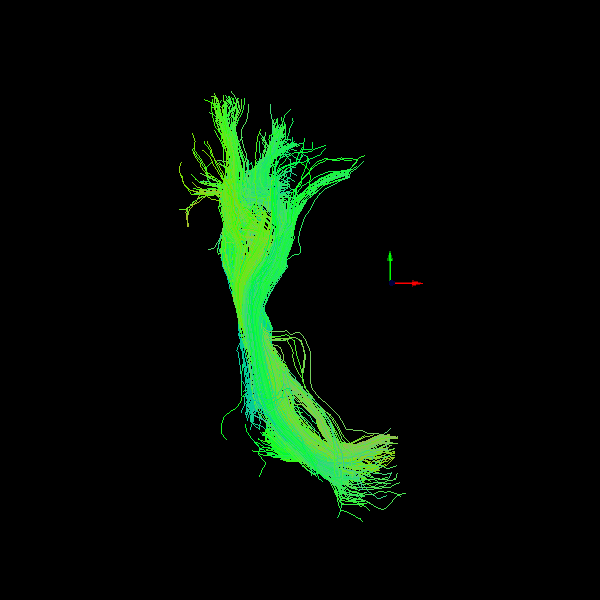

In [305]:
renpath=os.path.join(putdir, 'recognized_ILF_L_TRIO.png')
genren(rb_trio_ilf_L, putpath=renpath)
Image(renpath, width=400, height=400)

# Uncinate

In [306]:
template_unc = os.path.join(template_basepath, 'Uncinate_L.trk')

t_tg_unc = loadtgm_newapi(template_unc)
t_sls_unc_prisma = t_tg_unc.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_unc_trio = t_tg_unc.copy().apply_affine(xfm_temp2trio).streamlines

## Uncinate Prisma

In [350]:
rb_prisma_unc_L,ig = run_rb(t_sls_unc_prisma, wb_rawprisma_sls, cluster_map_prisma, pruning_thr=8)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.002 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.027 sec. 

 Model bundle has 31 centroids
 Duration 0.029 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 14426
 Duration 0.497 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.807
 Number of iterations 61
 Matrix size (400, 600)
[[ 0.801 -0.09   0.126  1.044]
 [ 0.066  0.798  0.153 14.506]
 [-0.14  -0.14   0.791  2.151]
 [ 0.     0.     0.     1.   ]]
[  0.031  -3.471   2.853 -10.046   9.914   4.717   0.816]
 Duration 19.871 sec. 

# Prune streamlines using the MDF distance
 P

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


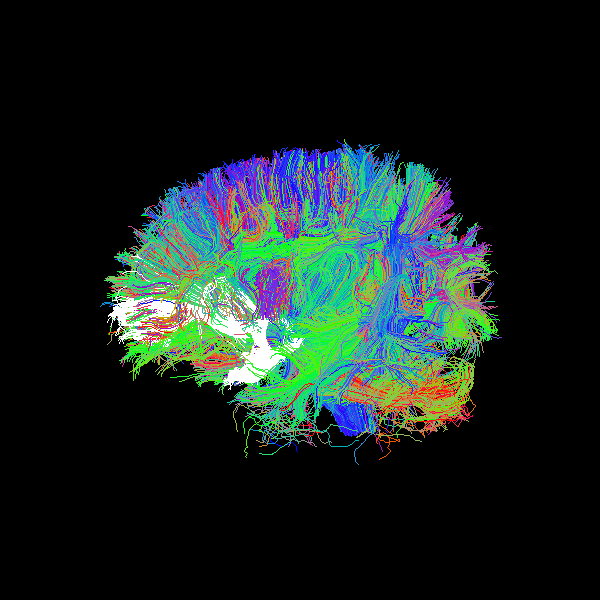

In [308]:
renpath=os.path.join(putdir, 'WB_UNC_L.png')
genren(wb_longprisma_sls[::100], t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Uncinate Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


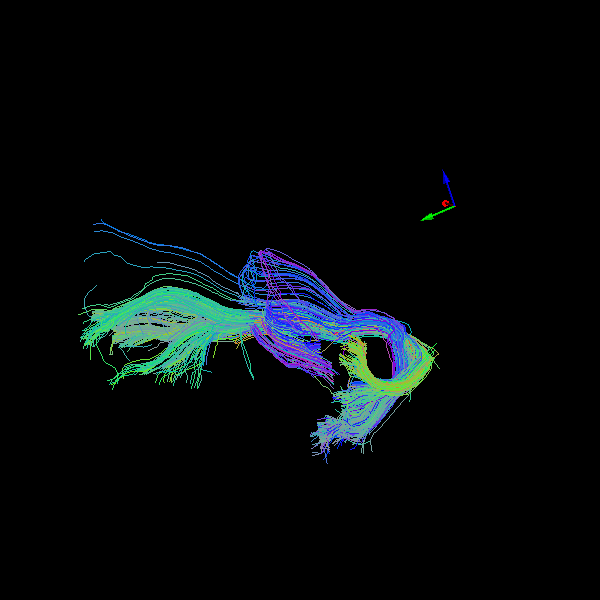

In [231]:
renpath=os.path.join(putdir, 'template_UNC_L.png')
genren(t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Uncinate Prisma

Pruning threshold = 5 (too small)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


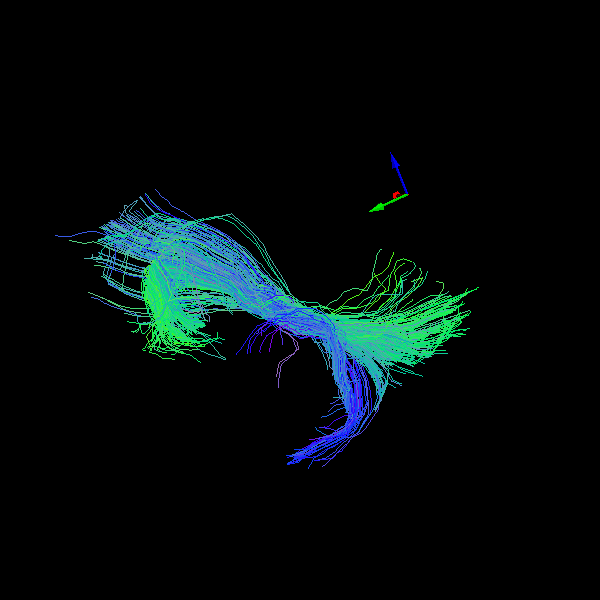

In [309]:
renpath=os.path.join(putdir, 'recognized_UNC_L.png')
genren(rb_prisma_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Pruning Threshold = 8

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


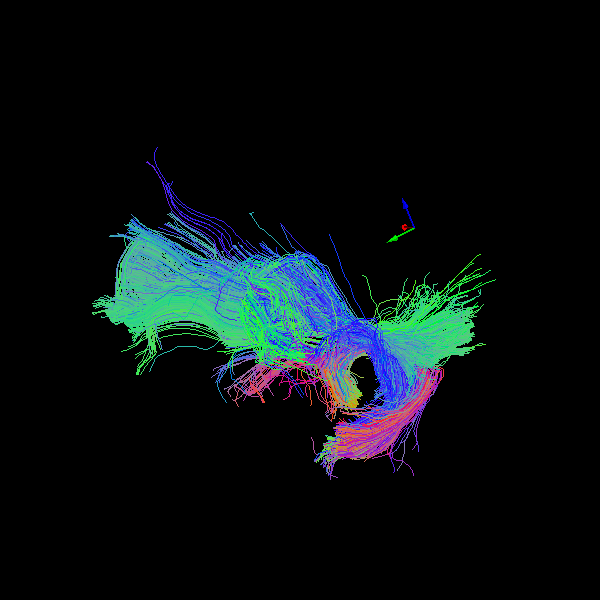

In [351]:
renpath=os.path.join(putdir, 'recognized_UNC_L.png')
genren(rb_prisma_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Trio Uncinate

In [352]:
rb_trio_unc_L, ig = run_rb(t_sls_unc_trio, wb_rawtrio_sls, cluster_map_trio, pruning_thr=8)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.002 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.026 sec. 

 Model bundle has 25 centroids
 Duration 0.027 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 7432
 Duration 0.394 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.644
 Number of iterations 39
 Matrix size (400, 600)
[[ 0.798  0.038 -0.046 -8.334]
 [-0.032  0.793  0.104  8.55 ]
 [ 0.05  -0.102  0.792  9.563]
 [ 0.     0.     0.     1.   ]]
[ -5.824 -10.804  -2.397  -7.333  -3.594  -2.28    0.8  ]
 Duration 9.852 sec. 

# Prune streamlines using the MDF distance
 Pru

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


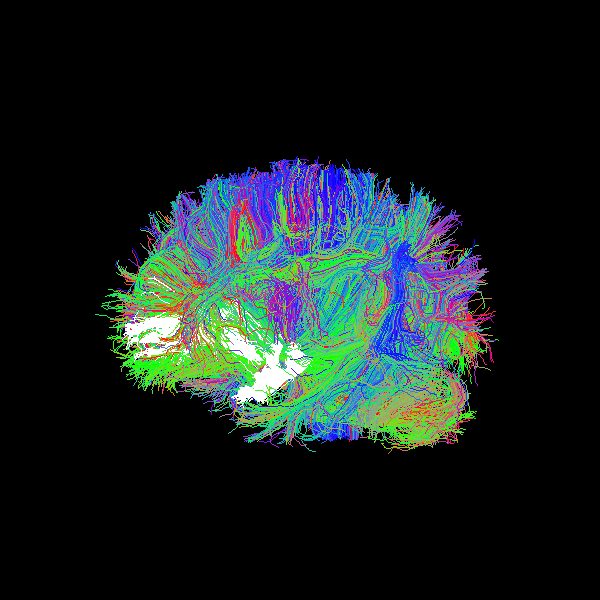

In [313]:
renpath=os.path.join(putdir, 'WB_UNC_L_TRIO.png')
genren(wb_longtrio_sls[::100], t_sls_unc_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template Uncinate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


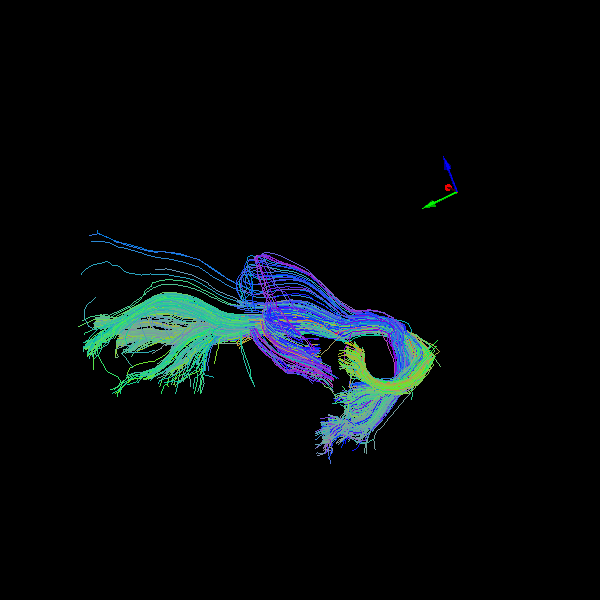

In [235]:
renpath=os.path.join(putdir, 'template_UNC_L.png')
genren(t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Uncinate Trio

Pruning threshold = 5 (too small)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


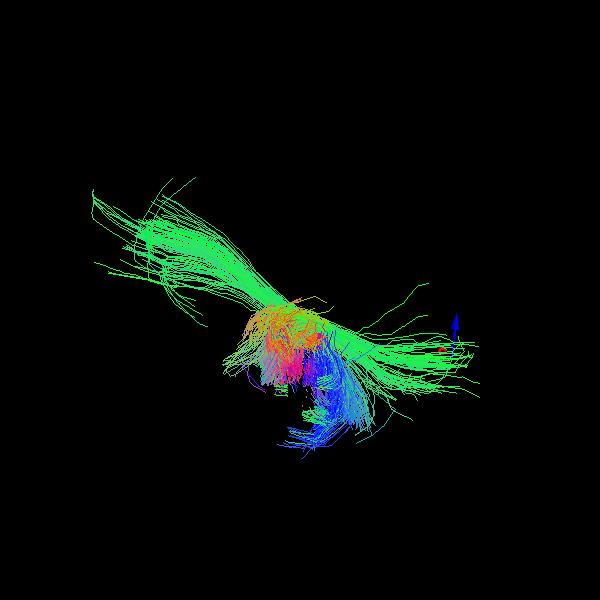

In [314]:
renpath=os.path.join(putdir, 'recognized_UNC_L_TRIO.png')
genren(rb_trio_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Pruning threshold = 8

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


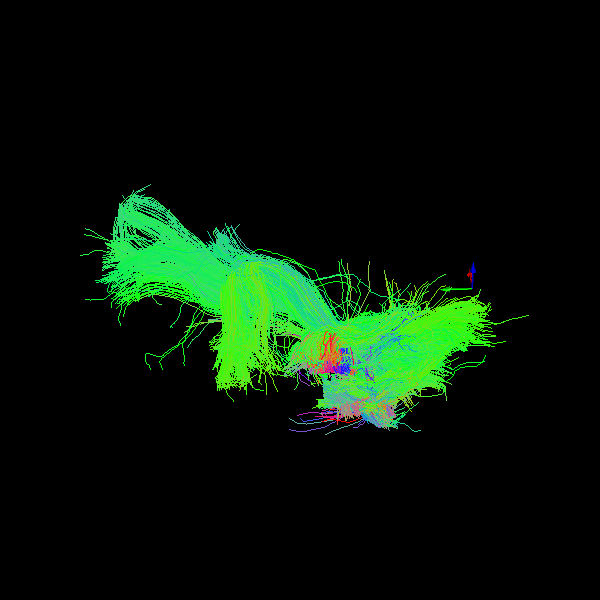

In [353]:
renpath=os.path.join(putdir, 'recognized_UNC_L_TRIO.png')
genren(rb_trio_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# Aslant

In [315]:
template_aslant = os.path.join(template_basepath, 'Aslant_L.trk')

t_tg_aslant = loadtgm_newapi(template_aslant)
t_sls_aslant_prisma = t_tg_aslant.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_aslant_trio = t_tg_aslant.copy().apply_affine(xfm_temp2trio).streamlines

## Prisma Aslant

In [316]:
rb_prisma_aslant_L, ig = run_rb(t_sls_aslant_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.003 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.041 sec. 

 Model bundle has 16 centroids
 Duration 0.044 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 12727
 Duration 0.356 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.028
 Number of iterations 71
 Matrix size (400, 600)
[[ 0.906 -0.022  0.048 -2.735]
 [ 0.026  0.905 -0.069 -0.225]
 [-0.046  0.07   0.904  2.09 ]
 [ 0.     0.     0.     1.   ]]
[ 3.619 -0.903  1.392  4.451  2.934  1.614  0.908]
 Duration 19.232 sec. 

# Prune streamlines using the MDF distance
 Pruning

#### Aslant Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


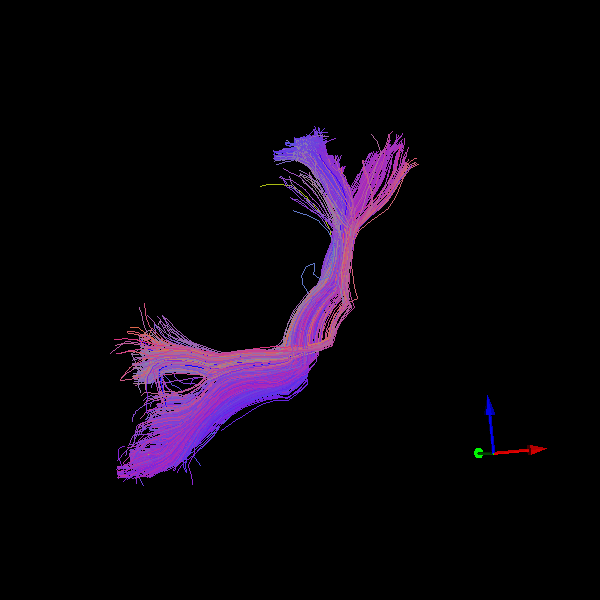

In [239]:
renpath=os.path.join(putdir, 'template_Aslant_L.png')
genren(t_sls_aslant_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Aslant Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


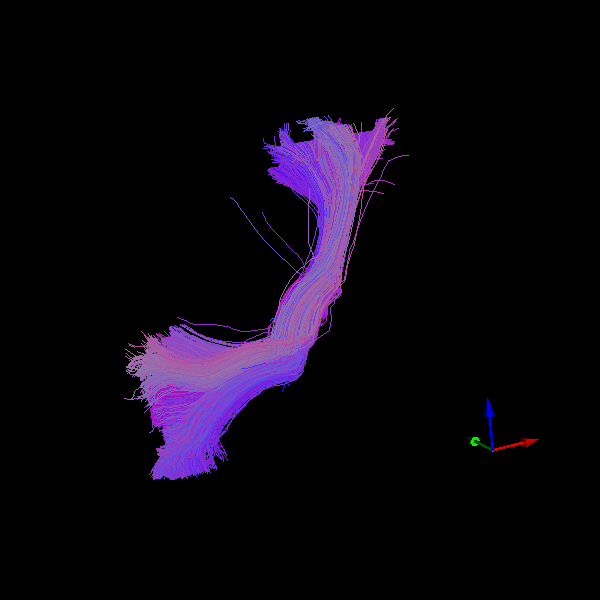

In [317]:
renpath=os.path.join(putdir, 'recognized_Aslant_L.png')
genren(rb_prisma_aslant_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Aslant Prisma

In [318]:
gold=glob(os.path.join(gs_prisma_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


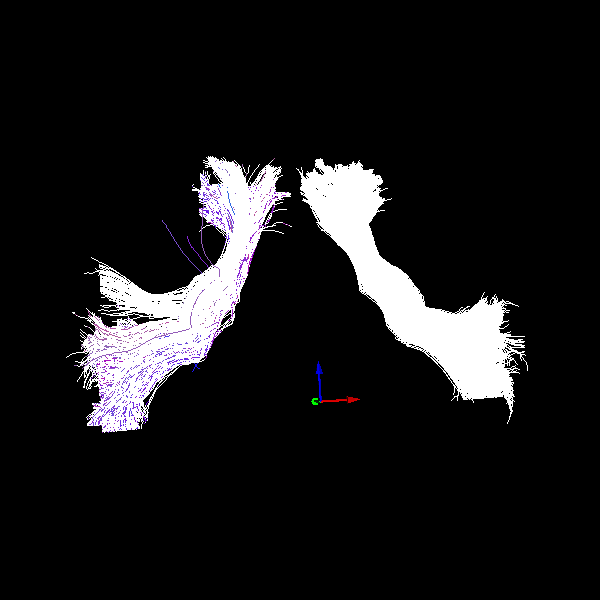

In [319]:
renpath=os.path.join(putdir, 'gold_Aslant_L_PRISMA_WHOLEBRAIN.png')
genren(rb_prisma_aslant_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Trio Aslant

In [320]:
rb_trio_aslant_L, ig = run_rb(t_sls_aslant_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.003 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.039 sec. 

 Model bundle has 15 centroids
 Duration 0.043 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 5208
 Duration 0.263 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 2.613
 Number of iterations 89
 Matrix size (400, 600)
[[ 0.895 -0.048  0.101 -4.496]
 [ 0.06   0.893 -0.111  3.653]
 [-0.094  0.117  0.889 -2.315]
 [ 0.     0.     0.     1.   ]]
[1.009 0.572 0.36  7.475 5.976 3.869 0.902]
 Duration 24.213 sec. 

# Prune streamlines using the MDF distance
 Pruning thresho

#### Template Aslant

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


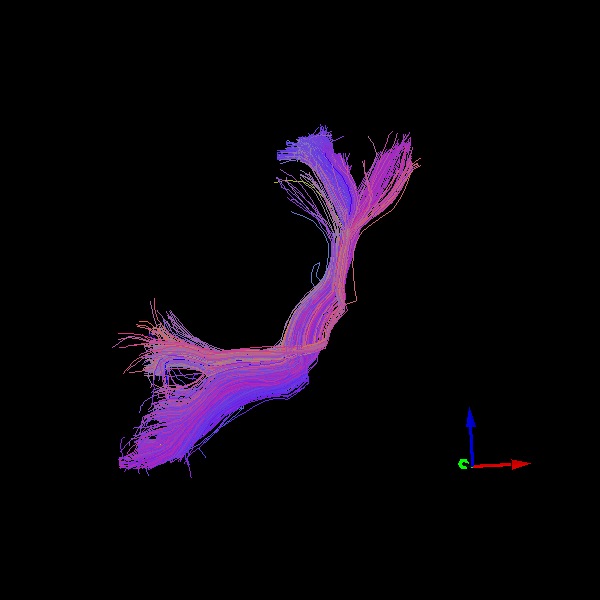

In [244]:
renpath=os.path.join(putdir, 'template_Aslant_L.png')
genren(t_sls_aslant_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Aslant Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


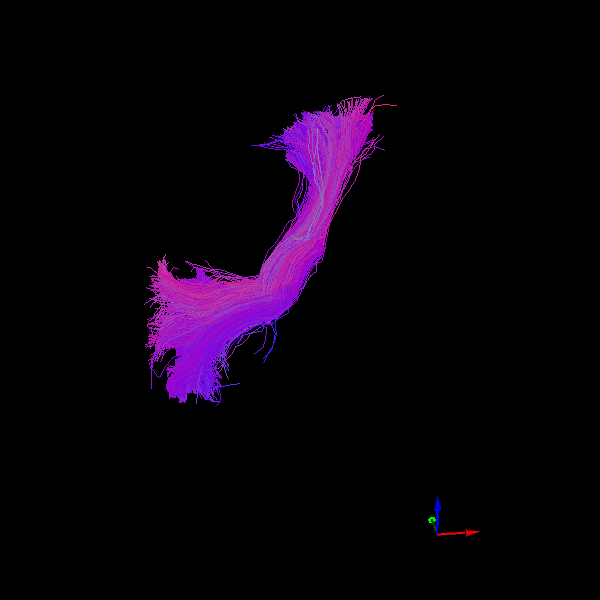

In [321]:
renpath=os.path.join(putdir, 'recognized_Aslant_L_TRIO.png')
genren(rb_trio_aslant_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Aslant Trio

In [322]:
gold=glob(os.path.join(gs_trio_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


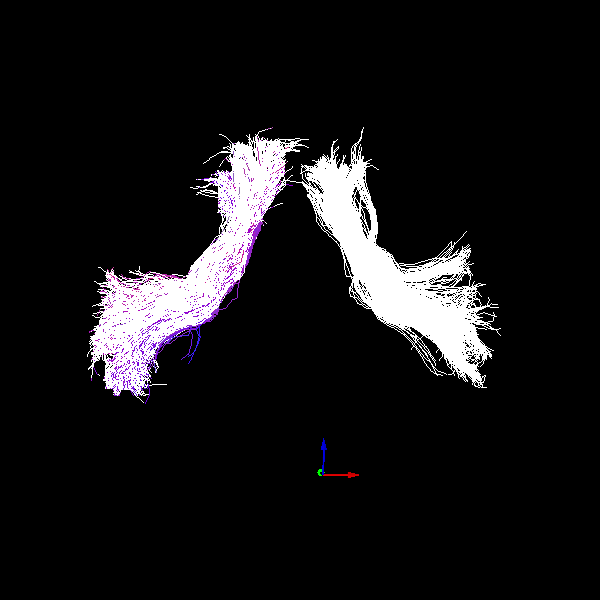

In [323]:
renpath=os.path.join(putdir, 'gold_Aslant_L_TRIO_WHOLEBRAIN.png')
genren(rb_trio_aslant_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# Arcuate

In [324]:
template_arcuate = os.path.join(template_basepath, 'Arcuate_L.trk')

t_tg_arcuate = loadtgm_newapi(template_arcuate)
t_sls_arcuate_prisma = t_tg_arcuate.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_arcuate_trio = t_tg_arcuate.copy().apply_affine(xfm_temp2trio).streamlines

## Arcuate Prisma

In [325]:
rb_prisma_arcuate_L, ig = run_rb(t_sls_arcuate_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 19566 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 4.478 MB
 Duration of resampling is 0.029 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.794 sec. 

 Model bundle has 289 centroids
 Duration 0.824 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 16701
 Duration 2.407 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.193
 Number of iterations 44
 Matrix size (400, 600)
[[ 1.068 -0.018  0.099  4.333]
 [ 0.023  1.071 -0.052  1.567]
 [-0.098  0.054  1.067 -2.135]
 [ 0.     0.     0.     1.   ]]
[-0.81  -1.174  0.819  2.881  5.267  1.25   1.073]
 Duration 12.411 sec. 

# Prune streamlines using the MDF distance
 Pruni

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


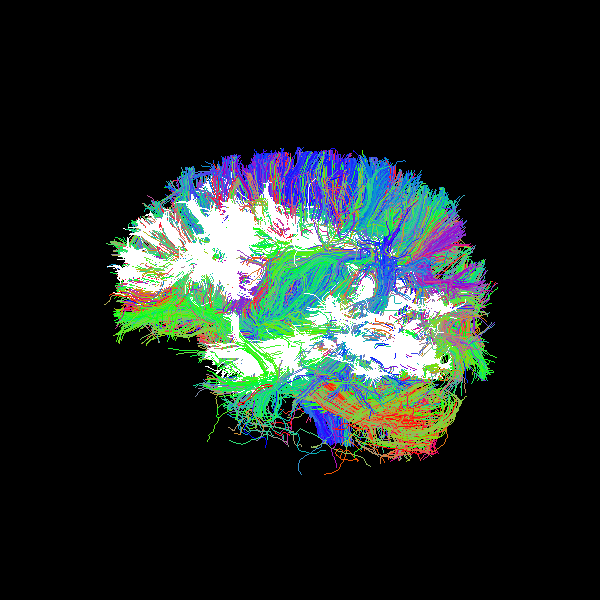

In [326]:
renpath=os.path.join(putdir, 'WB_Arcuate_L.png')
genren(wb_longprisma_sls[::100], t_sls_arcuate_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template Arcuate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


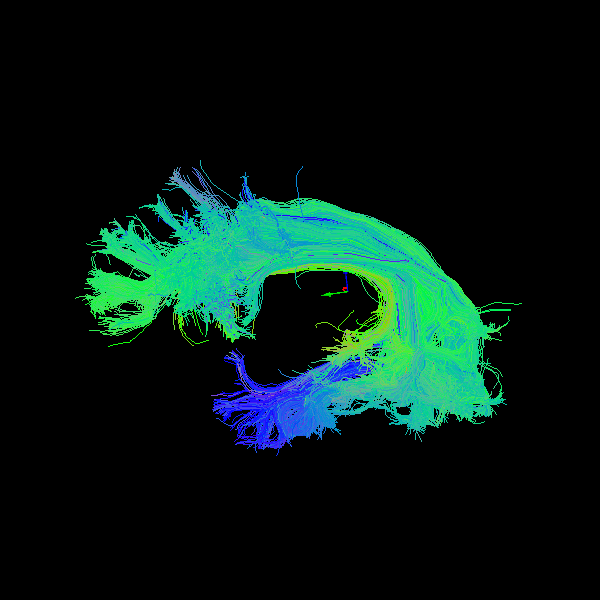

In [251]:
renpath=os.path.join(putdir, 'template_Arcuate_L.png')
genren(t_sls_arcuate_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Arcuate Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


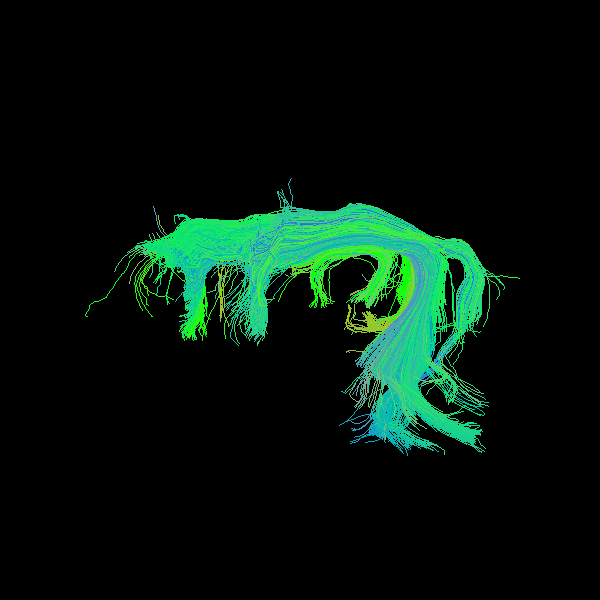

In [327]:
renpath=os.path.join(putdir, 'recognized_Arcuate_L.png')
genren(rb_prisma_arcuate_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Arcuate Prisma

In [328]:
gold=glob(os.path.join(gs_prisma_path, 'Arcuate_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


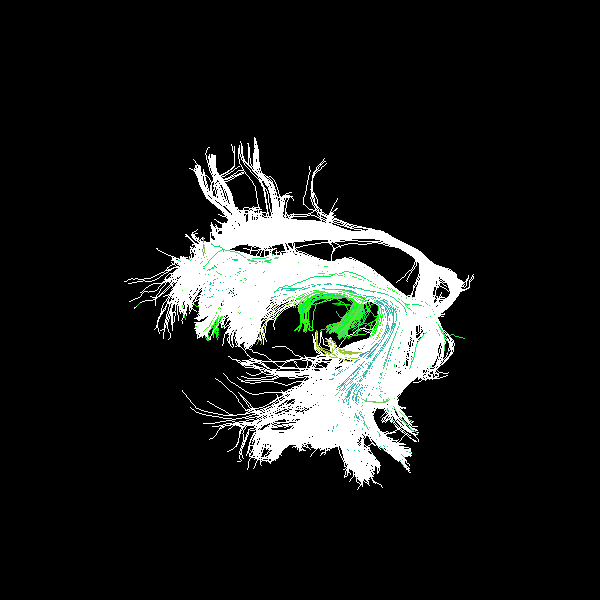

In [329]:
renpath=os.path.join(putdir, 'gold_Arcuate_L.png')
genren(rb_prisma_arcuate_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Arcuate Trio

In [330]:
rb_trio_arcuate_L, ig = run_rb(t_sls_arcuate_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 19566 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 4.478 MB
 Duration of resampling is 0.026 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.811 sec. 

 Model bundle has 265 centroids
 Duration 0.838 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 15594
 Duration 2.590 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 10.610
 Number of iterations 51
 Matrix size (400, 600)
[[ 1.002  0.007  0.107 -0.643]
 [-0.006  1.008 -0.005 -1.532]
 [-0.107  0.004  1.002 -4.75 ]
 [ 0.     0.     0.     1.   ]]
[-0.576 -1.95   0.847  0.224  6.07  -0.361  1.008]
 Duration 13.198 sec. 

# Prune streamlines using the MDF distance
 Prun

#### Template Arcuate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


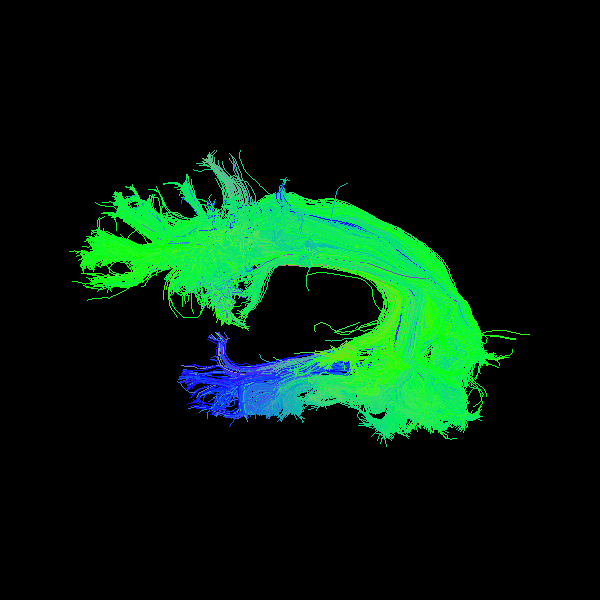

In [331]:
renpath=os.path.join(putdir, 'template_Arcuate_L_TRIO.png')
genren(t_sls_arcuate_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Arcuate Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


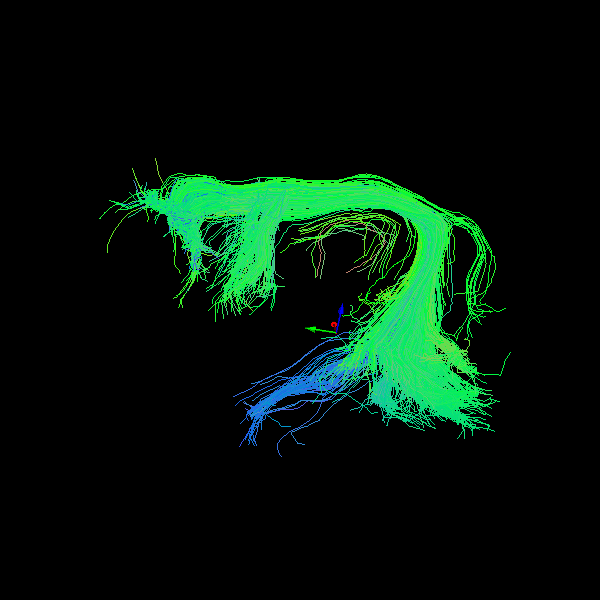

In [332]:
renpath=os.path.join(putdir, 'recognized_Arcuate_L.png')
genren(rb_trio_arcuate_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# SLF-IP

In [333]:
template_ip = os.path.join(template_basepath, 'SLF_IP_L.trk')

t_tg_slfip = loadtgm_newapi(template_ip)
t_sls_slfip_prisma = t_tg_slfip.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_slfip_trio = t_tg_slfip.copy().apply_affine(xfm_temp2trio).streamlines

## SLF-IP Prisma

In [334]:
rb_prisma_slfip_L, ig = run_rb(t_sls_slfip_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 9201 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.106 MB
 Duration of resampling is 0.013 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.317 sec. 

 Model bundle has 164 centroids
 Duration 0.330 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 24158
 Duration 1.400 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.251
 Number of iterations 54
 Matrix size (400, 600)
[[ 0.916  0.024  0.211 -3.002]
 [ 0.019  0.921 -0.188 -2.443]
 [-0.211  0.187  0.897 -2.59 ]
 [ 0.     0.     0.     1.   ]]
[-4.658  0.273 -0.22  11.777 13.001  1.196  0.94 ]
 Duration 14.662 sec. 

# Prune streamlines using the MDF distance
 Prunin

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


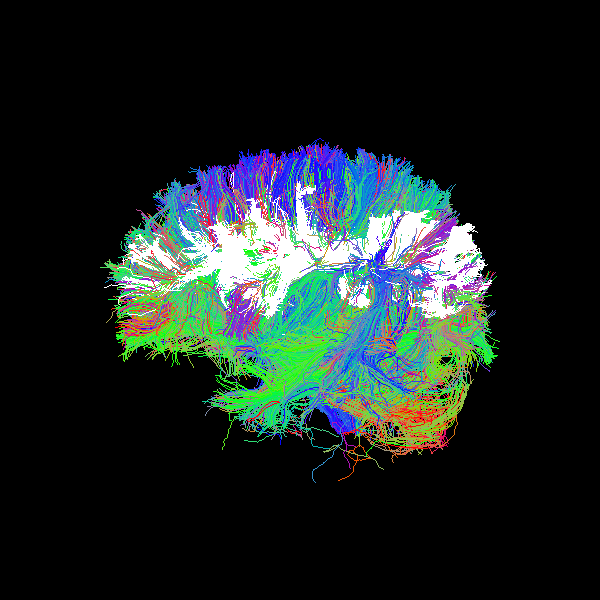

In [335]:
renpath=os.path.join(putdir, 'WB_SLFIP_L.png')
genren(wb_longprisma_sls[::100], t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### SLF-IP Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


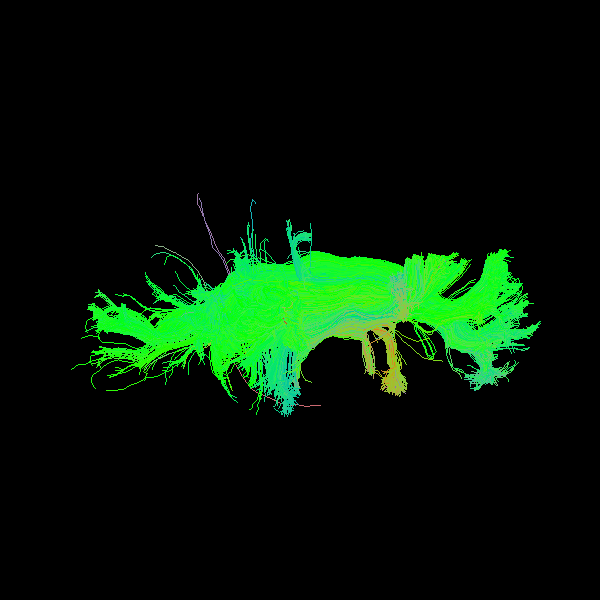

In [261]:
renpath=os.path.join(putdir, 'template_SLFIP_L.png')
genren(t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


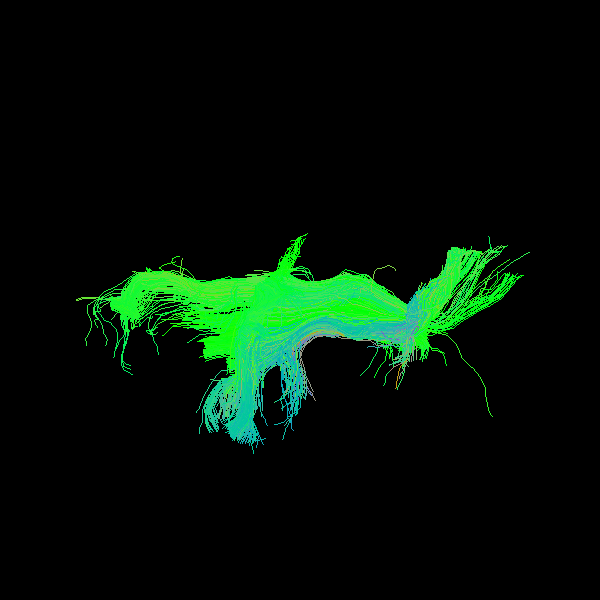

In [336]:
renpath=os.path.join(putdir, 'recognized_SLFIP_L.png')
genren(rb_prisma_slfip_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

There is a little extra truncated Arcuate included in this SLF-IP model

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


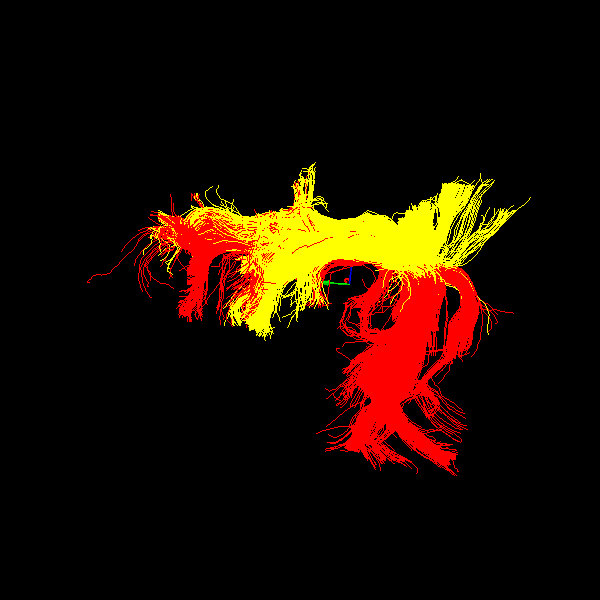

In [337]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFIP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slfip_L, putpath=renpath, show=True, colors=[(1,1,0),(1,0,0)])
Image(renpath, width=400, height=400)

## SLF-IP Trio

In [338]:
rb_trio_slfip_L, ig = run_rb(t_sls_slfip_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 9201 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.106 MB
 Duration of resampling is 0.013 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.359 sec. 

 Model bundle has 146 centroids
 Duration 0.373 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 18657
 Duration 1.523 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.196
 Number of iterations 48
 Matrix size (400, 600)
[[  0.825   0.116   0.351 -20.727]
 [ -0.045   0.883  -0.188   1.301]
 [ -0.367   0.155   0.811  -6.017]
 [  0.      0.      0.      1.   ]]
[-4.172  2.47  -4.349 10.798 23.95  -3.091  0.904]
 Duration 13.442 sec. 

# Prune streamlines using the MDF 

#### SLF-IP Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


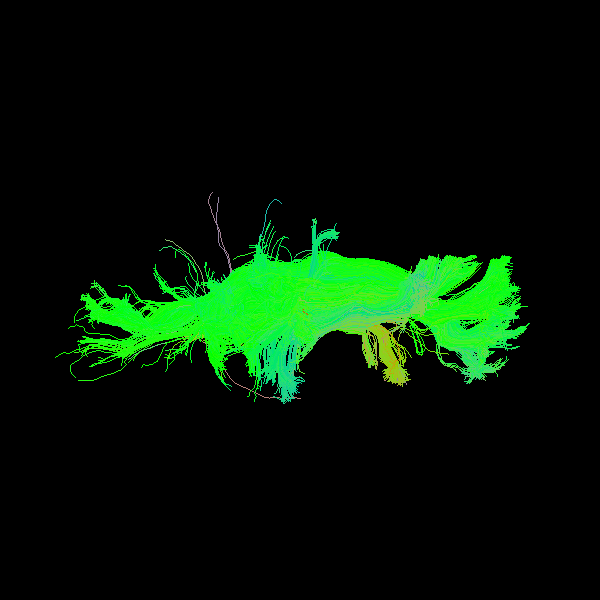

In [339]:
renpath=os.path.join(putdir, 'template_SLFIP_L.png')
genren(t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### SLF-IP Recognized Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


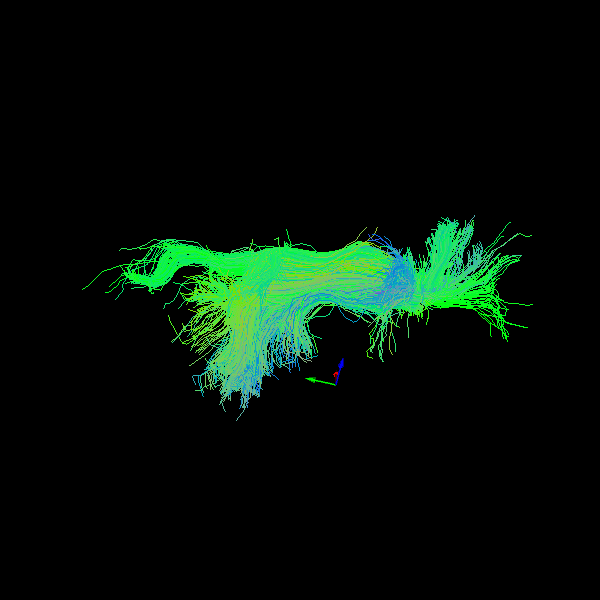

In [340]:
renpath=os.path.join(putdir, 'recognized_SLFIP_L_TRIO.png')
genren(rb_trio_slfip_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# SLF-tp

In [341]:
template_tp = os.path.join(template_basepath, 'SLF-tp_L.trk')
t_tg_slftp = loadtgm_newapi(template_tp)
t_sls_slftp_prisma = t_tg_slftp.copy().apply_affine(xfm_temp2prisma).streamlines
t_sls_slftp_trio = t_tg_slftp.copy().apply_affine(xfm_temp2trio).streamlines

## SLF-tp Prisma

In [342]:
rb_prisma_slftp_L, ig = run_rb(t_sls_slftp_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 2226 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.509 MB
 Duration of resampling is 0.004 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.069 sec. 

 Model bundle has 26 centroids
 Duration 0.074 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 21628
 Duration 0.520 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.857
 Number of iterations 48
 Matrix size (400, 600)
[[ 0.792 -0.02   0.112 -7.231]
 [ 0.043  0.781 -0.166 -4.627]
 [-0.106  0.171  0.774  1.505]
 [ 0.     0.     0.     1.   ]]
[ 0.511 -3.34   0.214 12.423  7.589  3.127  0.8  ]
 Duration 13.321 sec. 

# Prune streamlines using the MDF distance
 Pruning

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


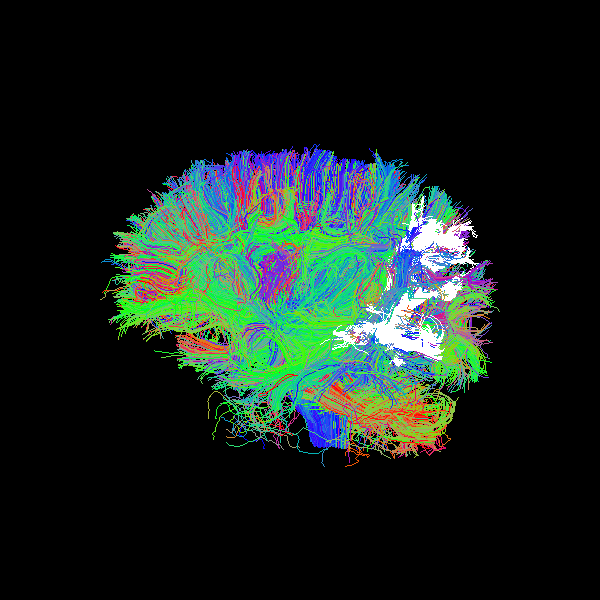

In [343]:
renpath=os.path.join(putdir, 'WB_SLFTP_L.png')
genren(wb_longprisma_sls[::100], t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template SLF-tp

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


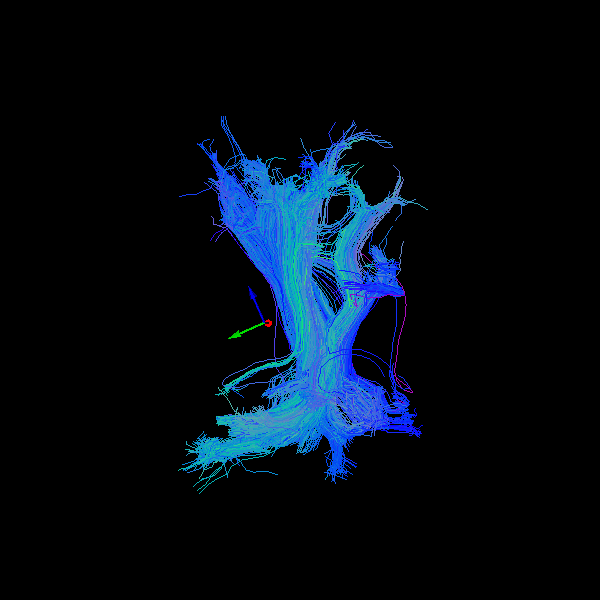

In [271]:
renpath=os.path.join(putdir, 'template_SLFTP_L.png')
genren(t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized SLF-tp Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


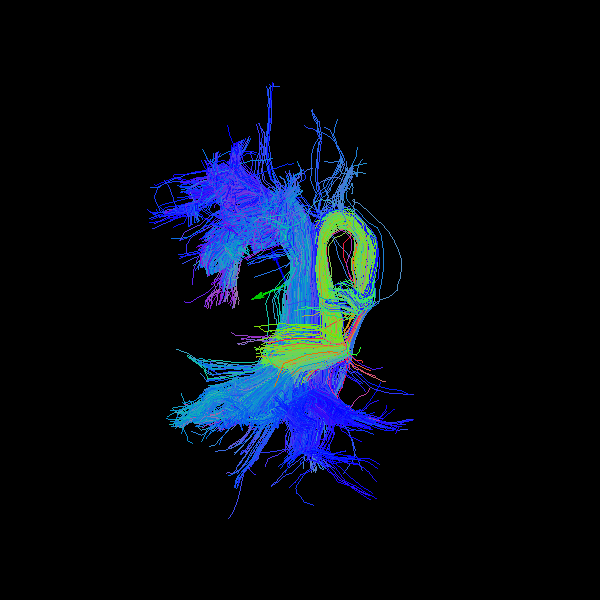

In [344]:
renpath=os.path.join(putdir, 'recognized_SLFTP_L.png')
genren(rb_prisma_slftp_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


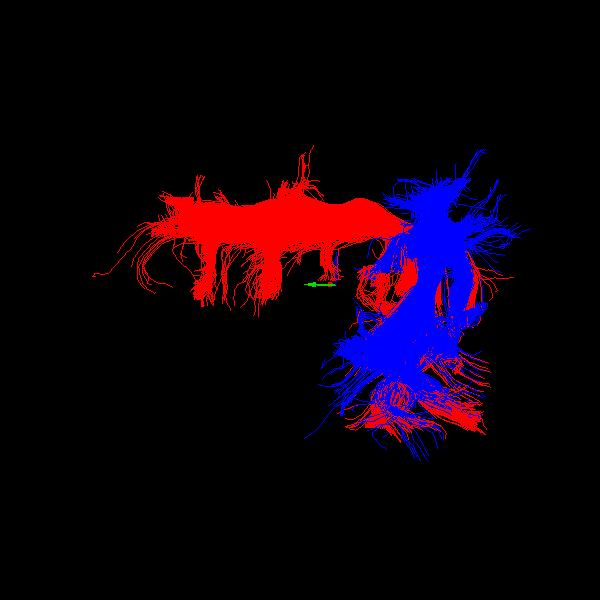

In [345]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFTP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,0,0)])
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


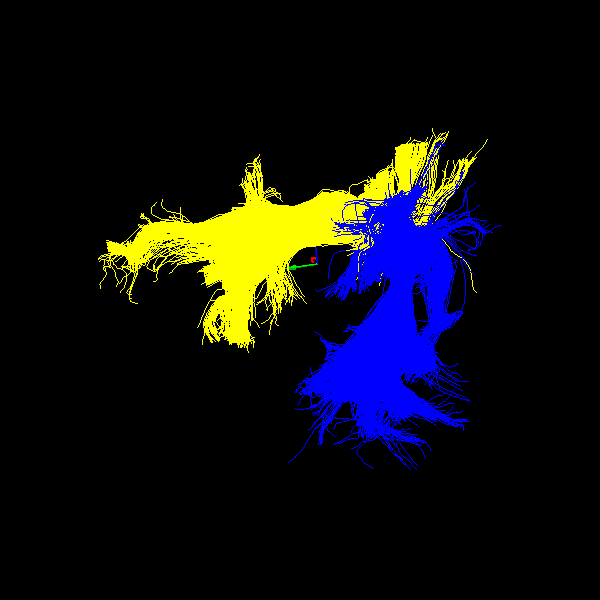

In [346]:
renpath=os.path.join(putdir, 'SLFIP_vs_SLFTP_L.png')
genren(rb_prisma_slfip_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,1,0)])
Image(renpath, width=400, height=400)

## SLF-tp Trio

In [347]:
rb_trio_slftp_L, ig = run_rb(t_sls_slftp_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 2226 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.509 MB
 Duration of resampling is 0.004 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.062 sec. 

 Model bundle has 27 centroids
 Duration 0.066 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 11847
 Duration 0.417 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.040
 Number of iterations 59
 Matrix size (400, 600)
[[ 0.902 -0.043  0.23  -9.66 ]
 [ 0.077  0.92  -0.13   2.584]
 [-0.221  0.145  0.894 -4.598]
 [ 0.     0.     0.     1.   ]]
[ 1.326 -2.327 -0.593  9.232 13.726  4.864  0.932]
 Duration 16.831 sec. 

# Prune streamlines using the MDF distance
 Pruning

#### Template SLF-tp

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


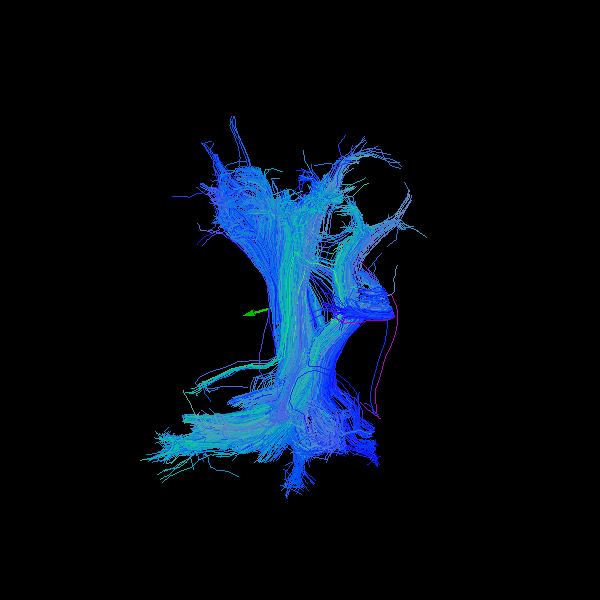

In [276]:
renpath=os.path.join(putdir, 'template_SLFTP_L.png')
genren(t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized SLF-tp Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


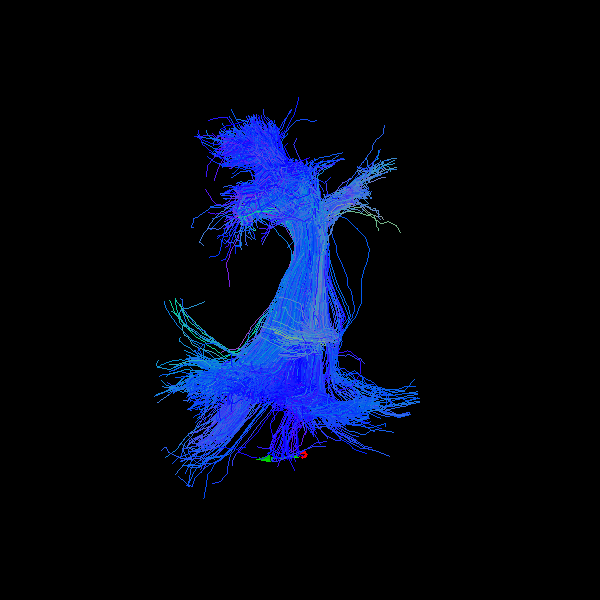

In [348]:
renpath=os.path.join(putdir, 'recognized_SLFTP_L_TRIO.png')
genren(rb_trio_slftp_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Notes:

- static = template; moving = patient (trio/prisma)

- Try pruning thresh = 5

- Improve template
    - bundle atlas online??
    - Frank Yeh? (link) N=100 bundles
    - CC one bundle
    - DSI studio

- Improve registration? 

- Try w/healthy datasets diffeo w/FA
    - PR by Conner for streamline handling
    https://github.com/nipy/dipy/pull/1398
    - DISABLE LOCAL SLR b/c bundles are on top of each other
    - for WM: the local registrations more accurate than global
    - Note: try DTI-TK and/or 
    
 - Now that you have a bundle extracted, it allows you to interactively expand
 
 - IIT
 
 - SLR re-register and reprune
    

Similarity Projection